<h1>Amazon Fine Food Reviews Analysis</h1>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:
<ol>
<li>Id</li>
<li>ProductId - unique identifier for the product</li>
<li>UserId - unqiue identifier for the user</li>
<li>ProfileName</li>
<li>HelpfulnessNumerator - number of users who found the review helpful</li>
<li>HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not</li>
<li>Score - rating between 1 and 5</li>
<li>Time - timestamp for the review</li>
<li>Summary - brief summary of the review</li>
<li>Text - text of the review</li>
</ol>
<b>Objective:-</b> Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

<h3>Loading the data</h3>

The dataset is available in two forms

1.csv file
2.SQLite Database
In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
con=sqlite3.connect("C:/Users/Aleti Sunil/Downloads/18_2157_compressed_database.sqlite/database.sqlite")

In [3]:
filtered_data=pd.read_sql_query("""
select * from reviews where Score!=3 """,con)

In [4]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Taking Scores of  1,2,4,5 <br>
1,2 represents negative
4,5 represents positive

In [5]:
def PositiveNegative(x):
    if x<3:
        return '0'
    return '1'
filtered_data["Score"]=filtered_data["Score"].map(PositiveNegative)
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
#No.of Positive and Negative classes
filtered_data["Score"].value_counts()

1    443777
0     82037
Name: Score, dtype: int64

In [7]:
filtered_data=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

In [8]:
filtered_data.shape

(364173, 10)

In [9]:
filtered_data=filtered_data[filtered_data["HelpfulnessNumerator"]<=filtered_data["HelpfulnessDenominator"]]
filtered_data.shape

(364171, 10)

In [10]:
filtered_data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

<h1>Text Preprocessing: Stemming, stop-word removal and Lemmatization.</h1>

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.
<h3>Hence in the Preprocessing phase we do the following in the order below:-</h3><br>
Begin by removing the html tags.<br>
Remove any punctuations or limited set of special characters like , or . or # etc.<br>
Check if the word is made up of english letters and is not alpha-numeric<br>
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)<br>
Convert the word to lowercase<br>
Remove Stopwords<br>
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
sent_1000=filtered_data["Text"].values[1000]
print(sent_1000)
print("*"*100)
sent_20=filtered_data["Text"].values[20]
print(sent_20)

This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?
****************************************************************************************************
My husband is a Twizzlers addict.  We've bought these many times from Amazon because we're government employees living overseas and can't get them in the country we are assigned to.  They've always been fresh and tasty, packed well and arrive in a timely manner.


In [12]:
#To remove urls in reviews:
sent_1000 = re.sub(r"http\S+", "", sent_1000)
#To remove html tags in reviews:
from bs4 import BeautifulSoup
soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print('*'*20)
#To remove words with numbers
sent_1000 = re.sub("\S*\d\S*", "", sent_1000)
print(sent_1000)
print('*'*20)
#replacing 't with "not"
def decontracted(phrase):
    phrase = re.sub(r"\'t", "will not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
decontracted(sent_1000)
#To remove special characters and numericals
sent_1000=re.sub('[^A-Za-z]+', ' ', sent_1000)
print(sent_1000)
print('*'*100)


This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?
********************
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than  inches long and that certainly is not the size of a training treat! The dogs-  dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this wou

In [17]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
print(stop_words)

[nltk_data] Downloading package stopwords to C:\Users\Aleti
[nltk_data]     Sunil\AppData\Roaming\nltk_data...


{'after', 'are', 'from', 'shouldn', 'theirs', 'both', "she's", 'just', 'their', "isn't", 'haven', 'before', "you've", 'until', 'very', 'too', 'does', 'don', 'whom', 'against', 'once', 'on', 'o', "haven't", 'what', "won't", "you're", "mightn't", 'as', 'now', "you'd", 'nor', 'most', 'not', 'for', 'his', "doesn't", 'wasn', 'out', 'and', 'all', 'did', 'itself', 'over', 'will', 'd', 'he', 'hasn', 't', 'yourself', 'y', 'this', 'that', 'am', 'any', 'didn', 'it', 've', 'weren', "hasn't", 'has', 'few', 'up', 'should', 'a', 'while', 'doesn', 'herself', "needn't", 'mustn', 'other', 'why', "that'll", "shouldn't", 'have', 'so', 'me', 'its', 'ourselves', 'about', 'aren', 'there', 'through', 'because', 'above', 'can', 'be', 'having', 'such', 'yourselves', 'but', 'with', 'wouldn', 'do', 'she', 'was', "weren't", 'how', 'hadn', 'her', 'hers', 'between', 'i', "didn't", 'ours', 'we', 'ain', 'won', 'himself', 'had', 'being', 'myself', 'doing', 're', 'shan', 'the', 'our', 'each', 'then', 'than', 'been', 'ag

[nltk_data]   Package stopwords is already up-to-date!


In [18]:
filtered_data.shape

(364171, 10)

In [19]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(filtered_data['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop_words and len(e.lower())>2)
    s=sno.stem(sentance) #snoball stemmer
    preprocessed_reviews.append(s.strip())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [04:38<00:00, 1307.25it/s]


In [20]:
filtered_data["CleanedText"]=preprocessed_reviews

In [21]:
filtered_data.head(5) #we can a new column has been added 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


In [25]:
print(filtered_data["CleanedText"].shape)
print(filtered_data["Score"].shape)

(364171,)
(364171,)


In [23]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score

<b>Sorting the reviews with respect to time</b>

In [26]:
filtered_data = filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
filtered_data.shape    

(364171, 11)

In [27]:
#Splitting Data
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = filtered_data['CleanedText'] #taking CleanedText into X
Y = filtered_data['Score']       #taking Score into Y

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0) #Taking 0.33 into Test
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [28]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (243994,) (243994,)
X_test, Y_test (120177,) (120177,)
X_tr, Y_tr (163475,) (163475,)
X_cv, Y_cv (80519,) (80519,)


In [29]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

<h3>Training Model</h3>

In [30]:
def mulnb(X_train,X_cv,Y_train,Y_cv):
    best_alpha=0
    max_roc_auc=-1
    pred_cv = []
    pred_train = []
    alpha=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001] 
    for i in alpha[-19:]:
        mulbnb = MultinomialNB(alpha=i)
        mulbnb.fit(X_train,Y_train)
        probs = mulbnb.predict_proba(X_cv)
        prob = mulbnb.predict_proba(X_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(Y_cv,probs)
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," ------> ",auc_score_cv)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_alpha=i
    print(f"\n Best alpha Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(alpha, pred_cv,'r-', label = 'CV Data')
    plt.plot(alpha,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\alpha$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()

<h3>Testing</h3>

In [31]:
import scikitplot.metrics as skplt

def testing(X_train,Y_train,X_test,Y_test,optimal_alpha):
    bnb = MultinomialNB(optimal_alpha,fit_prior=True, class_prior=None)
    bnb.fit(X_train,Y_train)
    probs = bnb.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    
    prediction=bnb.predict(X_test)
    skplt.plot_confusion_matrix(Y_test,prediction)
    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))
    print(probs)

<h3>Vectorization using BOW</h3>

In [32]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (163475, 79563)
CV Data Size:  (80519, 79563)
Test Data Size:  (120177, 79563)


In [33]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (163475, 79563)
CV Data Size:  (80519, 79563)
Test Data Size:  (120177, 79563)


10000  ------>  0.6258449262455006
5000  ------>  0.6305960705126064
1000  ------>  0.6487858028691605
500  ------>  0.6580853769432105
100  ------>  0.6826762992935134
50  ------>  0.6976009851571647
10  ------>  0.763936328682423
5  ------>  0.8138958832706193
1  ------>  0.9185191802308301
0.5  ------>  0.9336567750696835
0.1  ------>  0.9409048485108857
0.05  ------>  0.9407553659698354
0.01  ------>  0.9369533927670989
0.005  ------>  0.9340010076790717
0.001  ------>  0.9248571553482374
0.0005  ------>  0.9202331526498724
0.0001  ------>  0.9086783489403853
5e-05  ------>  0.9035645303007285
1e-05  ------>  0.8918367342502

 Best alpha Value 0.1 with highest roc_auc Score is 0.9409048485108857


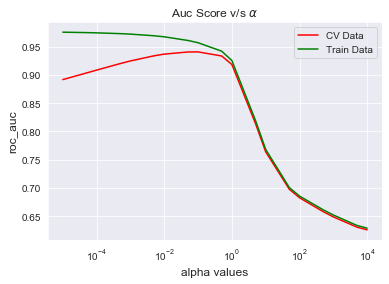

In [34]:
# find optimal alpha 
mulnb(bow_train,bow_cv,Y_tr,Y_cv)

AUC Score 0.9406719361192301
macro f1 score for data : 0.6472968098800108
micro f1 scoore for data: 0.8757416144520166
hamming loss for data: 0.1242583855479834
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.92      0.23      0.36     18848
           1       0.87      1.00      0.93    101329

    accuracy                           0.88    120177
   macro avg       0.90      0.61      0.65    120177
weighted avg       0.88      0.88      0.84    120177

[0.94836062 0.8010493  0.96031265 ... 0.88983131 0.99658319 0.95478868]


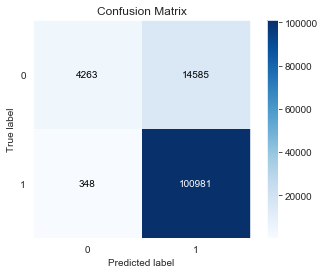

In [35]:
testing(bow_train,Y_tr,bow_test,Y_test,optimal_alpha=0.1)

<h3>Vectorization using TF-IDF</h3>

In [36]:
#tfidf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (163475, 2306210)
CV Data Size:  (80519, 2306210)
Test Data Size:  (120177, 2306210)


In [37]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (163475, 2306210)
CV Data Size:  (80519, 2306210)
Test Data Size:  (120177, 2306210)


10000  ------>  0.6393633651356851
5000  ------>  0.6403886035055844
1000  ------>  0.646793462449426
500  ------>  0.6522634567797235
100  ------>  0.673374680939848
50  ------>  0.6866112067749817
10  ------>  0.7269504048695193
5  ------>  0.7490560816472328
1  ------>  0.8207965039821703
0.5  ------>  0.8622018459089864
0.1  ------>  0.9371196888943515
0.05  ------>  0.9455772909348665
0.01  ------>  0.9385648356218955
0.005  ------>  0.9304560772159731
0.001  ------>  0.907730008912498
0.0005  ------>  0.8979321302861173
0.0001  ------>  0.8774180823963391
5e-05  ------>  0.869717965433623
1e-05  ------>  0.8542826129116644

 Best alpha Value 0.05 with highest roc_auc Score is 0.9455772909348665


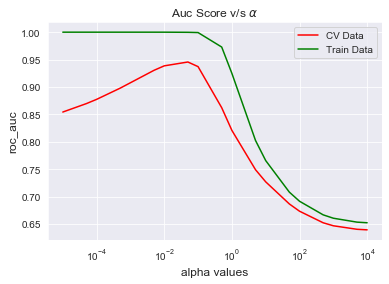

In [38]:
# find optimal_alpha
mulnb(tfidf_train,tfidf_cv,Y_tr,Y_cv)

AUC Score 0.946165738008254
macro f1 score for data : 0.703091933724117
micro f1 scoore for data: 0.8889554573670503
hamming loss for data: 0.11104454263294973
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.94      0.31      0.47     18848
           1       0.89      1.00      0.94    101329

    accuracy                           0.89    120177
   macro avg       0.91      0.65      0.70    120177
weighted avg       0.89      0.89      0.86    120177

[0.99851878 0.99274552 0.9961332  ... 0.99715957 0.99984182 0.99537934]


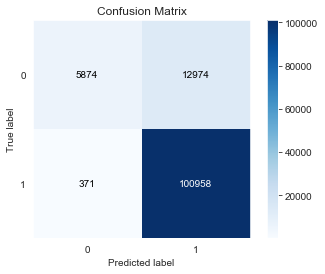

In [39]:
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_alpha=0.05)

In [41]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best hyper parameter(alpha)","Test Auc Score"]
x.add_row(["BoW","MultinomialNB",0.1,94.0])
x.add_row(["Tf-Idf","MultinomialNB",0.05,94.6])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+---------------+-----------------------------+----------------+
| Vectorizer |     Model     | Best hyper parameter(alpha) | Test Auc Score |
+------------+---------------+-----------------------------+----------------+
|    BoW     | MultinomialNB |             0.1             |      94.0      |
|   Tf-Idf   | MultinomialNB |             0.05            |      94.6      |
+------------+---------------+-----------------------------+----------------+
